In [1]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [2]:
path = 'mtcnn_filtered-20220427-180935'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [3]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [4]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-27 18:09:35.838415,13.6,3487215616
1,2022-04-27 18:09:47.108415,64.6,2682056704
2,2022-04-27 18:09:58.221414,46.6,2704216064
3,2022-04-27 18:10:09.249912,66.4,2720514048
4,2022-04-27 18:10:20.268913,67.0,2760200192
...,...,...,...
88,2022-04-27 18:26:07.860913,72.7,2915291136
89,2022-04-27 18:26:19.024913,70.9,2787078144
90,2022-04-27 18:26:30.142413,64.9,2810601472
91,2022-04-27 18:26:41.255414,67.8,2928447488


In [5]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

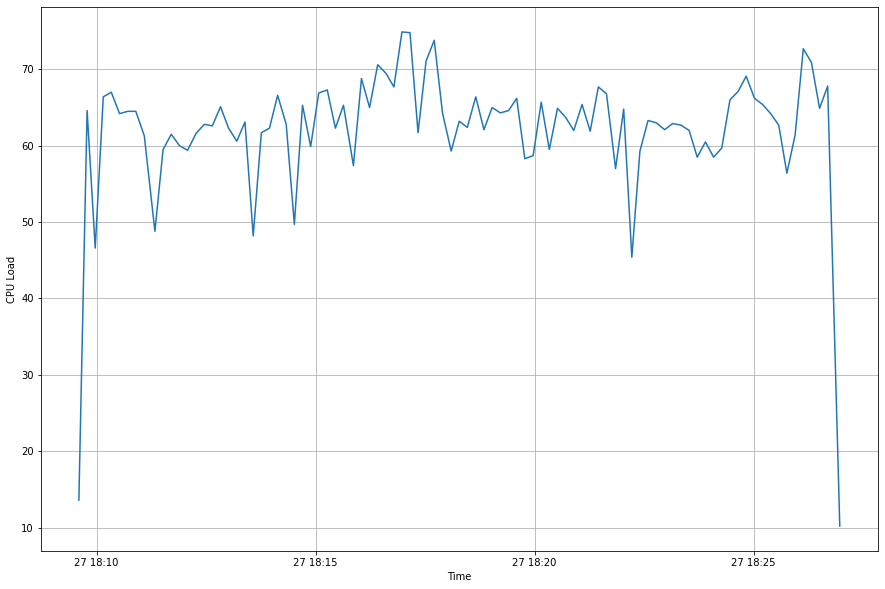

In [6]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

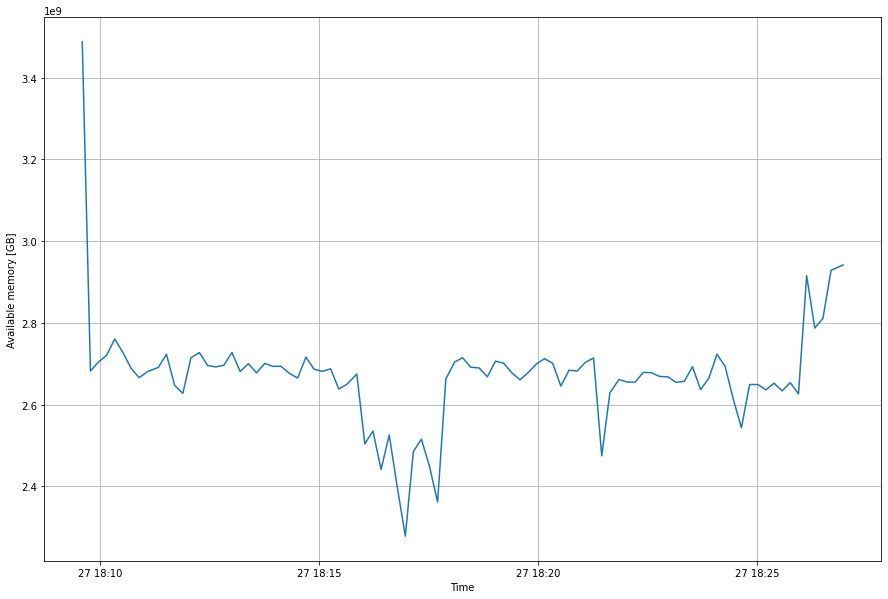

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

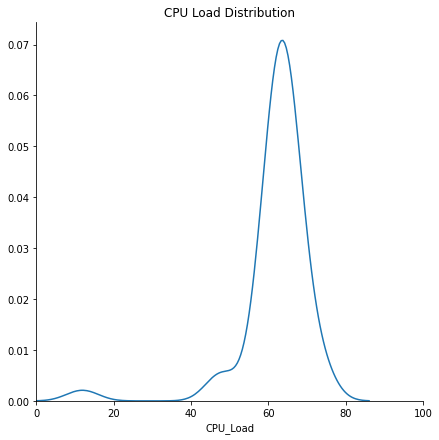

In [8]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

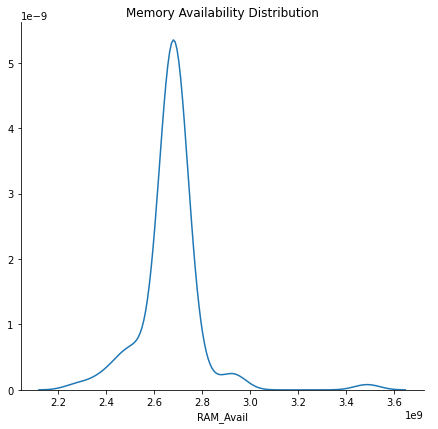

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [10]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-27 18:09:36.973413,395021300,1.0,1.0,1.0,"[0.8915242805755396, 0.8778703002775675, 0.771...",8,0,0,8,"[(176.0, 141.0, 255.0, 245.0), (785.0, 190.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-27 18:09:37.252912,273222900,0.0,0.0,0.0,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-27 18:09:37.474412,213252200,1.0,1.0,1.0,[0.8058647841433614],1,0,0,2,"[(551.0, 117.0, 604.0, 174.0), (459.0, 48.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-27 18:09:37.996416,376923200,0.0,0.0,0.0,[],0,0,0,62,"[(61.0, 494.0, 99.0, 541.0), (254.0, 496.0, 29...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-27 18:09:38.325413,297886100,1.0,1.0,1.0,"[0.8859470468431772, 0.8551800965466023, 0.807...",7,0,0,8,"[(268.0, 70.0, 317.0, 128.0), (410.0, 89.0, 45...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-27 18:26:46.657412,310235300,1.0,1.0,1.0,[0.7898197662903546],1,0,0,1,"[(457.0, 159.0, 584.0, 316.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-27 18:26:47.063913,398456500,1.0,1.0,1.0,"[0.767156406918356, 0.7021690767519466]",2,0,0,2,"[(715.0, 421.0, 797.0, 531.0), (331.0, 415.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-27 18:26:47.473413,311258300,0.0,0.0,0.0,[],0,0,0,27,"[(736.0, 501.0, 768.0, 540.0), (521.0, 479.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-27 18:26:47.621912,131437900,1.0,1.0,1.0,"[0.8199643493761141, 0.7321225879682179]",2,0,0,7,"[(855.0, 82.0, 901.0, 142.0), (113.0, 109.0, 1...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [11]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.738636e+08,0.683475,0.669819,0.664192,1.837260,0.140732,0.371668,12.308741
std,1.330600e+08,0.441002,0.438013,0.428772,2.628146,0.441319,0.976526,39.822258
min,7.519380e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.851072e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.472913e+08,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,3.270309e+08,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,9.000000
max,1.972906e+09,1.000000,1.000000,1.000000,33.000000,6.000000,16.000000,709.000000


In [12]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,1.000000,True,True,True
1,1.000000,True,True,True
2,1.000000,True,True,False
3,1.000000,True,True,True
4,1.000000,True,True,True
...,...,...,...,...
6376,0.701781,False,False,False
6377,0.701700,False,False,False
6378,0.701296,False,False,False
6379,0.700917,False,False,False


In [13]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [14]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,1.000000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,1.000000,True,True,False,1.000000,0.000421,1.000000,0.000421,0.666667,0.000281
3,1.000000,True,True,True,1.000000,0.000561,1.000000,0.000561,0.750000,0.000421
4,1.000000,True,True,True,1.000000,0.000702,1.000000,0.000702,0.800000,0.000561
...,...,...,...,...,...,...,...,...,...,...
6376,0.701781,False,False,False,0.930218,0.832445,0.907950,0.812518,0.710365,0.635700
6377,0.701700,False,False,False,0.930072,0.832445,0.907808,0.812518,0.710254,0.635700
6378,0.701296,False,False,False,0.929926,0.832445,0.907666,0.812518,0.710143,0.635700
6379,0.700917,False,False,False,0.929781,0.832445,0.907524,0.812518,0.710031,0.635700


In [15]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

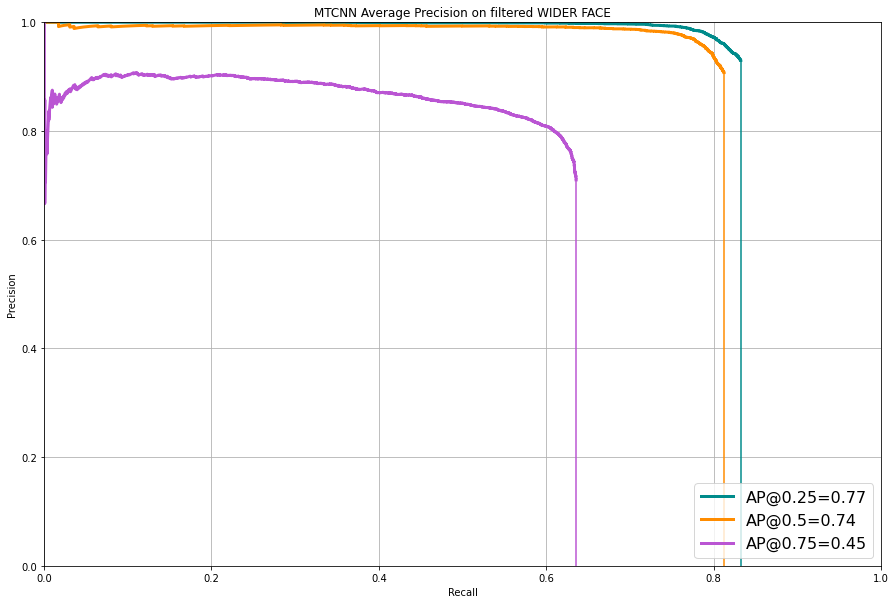

In [16]:
plot_pr(df_ap, 'MTCNN Average Precision on filtered WIDER FACE')